In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

from sklearn import metrics

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
#Import the dataset
dftrips_clean = pd.read_csv('trips_readyformodeling.csv')

In [3]:
dftrips_clean.shape

(2249788, 28)

In [4]:
dftrips_clean.head()

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,SUPPRESSED,...,pressure,humidity,wind_speed,wind_deg,wind_gust,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,2018-02-07 23:00:00,6253783,68,68_80,1,87245,84600,87524.0,84600.0,NaN,...,1015,87,7.2,220,NaN,NaN,NaN,75,Drizzle,light intensity drizzle
1,2018-02-07 23:00:00,6253175,14,14_15,1,85383,81600,84682.0,81608.0,NaN,...,1015,87,7.2,220,NaN,NaN,NaN,75,Drizzle,light intensity drizzle
2,2018-02-07 23:00:00,6259641,59,59_10,1,84864,84000,84890.0,84076.0,NaN,...,1015,87,7.2,220,NaN,NaN,NaN,75,Drizzle,light intensity drizzle
3,2018-02-07 23:00:00,6247763,77A,77A_29,1,86470,82800,NaN,82797.0,NaN,...,1015,87,7.2,220,NaN,NaN,NaN,75,Drizzle,light intensity drizzle
4,2018-02-07 23:00:00,6259918,16,16_20,1,85182,81000,84667.0,80996.0,NaN,...,1015,87,7.2,220,NaN,NaN,NaN,75,Drizzle,light intensity drizzle


## Preliminary Check and Data Preperation

In [5]:
dftrips_clean.dtypes

DAYOFSERVICE            object
TRIPID                   int64
LINEID                  object
ROUTEID                 object
DIRECTION                int64
PLANNEDTIME_ARR          int64
PLANNEDTIME_DEP          int64
ACTUALTIME_ARR         float64
ACTUALTIME_DEP         float64
SUPPRESSED             float64
TRIPTIME(min)            int64
HOUROFDAY              float64
DAYOFWEEK                int64
MONTHOFYEAR              int64
temp                   float64
visibility             float64
dew_point              float64
feels_like             float64
pressure                 int64
humidity                 int64
wind_speed             float64
wind_deg                 int64
wind_gust              float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
dtype: object

In [6]:
dftrips_clean.isna().sum()

DAYOFSERVICE                 0
TRIPID                       0
LINEID                       0
ROUTEID                      0
DIRECTION                    0
PLANNEDTIME_ARR              0
PLANNEDTIME_DEP              0
ACTUALTIME_ARR          141451
ACTUALTIME_DEP          170219
SUPPRESSED             2245288
TRIPTIME(min)                0
HOUROFDAY                    0
DAYOFWEEK                    0
MONTHOFYEAR                  0
temp                         0
visibility                6919
dew_point                    0
feels_like                   0
pressure                     0
humidity                     0
wind_speed                   0
wind_deg                     0
wind_gust              2033083
rain_1h                1793676
snow_1h                2243255
clouds_all                   0
weather_main                 0
weather_description          0
dtype: int64

In [7]:
#Convert the data into proper type.
categorical_columns = dftrips_clean[['TRIPID','LINEID','ROUTEID','weather_main','weather_description']].columns
datetime_columns = dftrips_clean[['DAYOFSERVICE']].columns
continuous_columns = dftrips_clean.select_dtypes(exclude = 'object')

for column in categorical_columns:
    dftrips_clean[column] = dftrips_clean[column].astype('category')  

for column in datetime_columns:
    dftrips_clean[column] = pd.to_datetime(dftrips_clean[column]).astype('datetime64') 
    
for column in continuous_columns:
    dftrips_clean[column] = dftrips_clean[column].astype('float64')
    
dftrips_clean['TRIPID'] = dftrips_clean['TRIPID'].astype('category')
    
dftrips_clean.dtypes

DAYOFSERVICE           datetime64[ns]
TRIPID                       category
LINEID                       category
ROUTEID                      category
DIRECTION                     float64
PLANNEDTIME_ARR               float64
PLANNEDTIME_DEP               float64
ACTUALTIME_ARR                float64
ACTUALTIME_DEP                float64
SUPPRESSED                    float64
TRIPTIME(min)                 float64
HOUROFDAY                     float64
DAYOFWEEK                     float64
MONTHOFYEAR                   float64
temp                          float64
visibility                    float64
dew_point                     float64
feels_like                    float64
pressure                      float64
humidity                      float64
wind_speed                    float64
wind_deg                      float64
wind_gust                     float64
rain_1h                       float64
snow_1h                       float64
clouds_all                    float64
weather_main

In [8]:
#Drop the columns of planned times and actual times.
dftrips_clean = dftrips_clean.drop(columns = ['PLANNEDTIME_ARR','PLANNEDTIME_DEP','ACTUALTIME_ARR','ACTUALTIME_DEP','SUPPRESSED'])

In [9]:
#Fill in the blank with 0.
dftrips_clean['visibility'].fillna(0, inplace=True)
dftrips_clean['wind_gust'].fillna(0, inplace=True)
dftrips_clean['rain_1h'].fillna(0, inplace=True)
dftrips_clean['snow_1h'].fillna(0, inplace=True)

### Randomly shuffle the rows of the dataset and split the dataset into two datasets: 70% training and 30% test.

In [10]:
# randomly generate sequence based on dataframe index and set to be new index
dftrips_clean.set_index(np.random.permutation(dftrips_clean.index))
# sort the resulting random index
dftrips_clean.sort_index(inplace=True)
dftrips_clean.head(5)

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,TRIPTIME(min),HOUROFDAY,DAYOFWEEK,MONTHOFYEAR,temp,...,pressure,humidity,wind_speed,wind_deg,wind_gust,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,2018-02-07 23:00:00,6253783.0,68,68_80,1.0,48.0,23.0,2.0,2.0,6.39,...,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
1,2018-02-07 23:00:00,6253175.0,14,14_15,1.0,51.0,23.0,2.0,2.0,6.39,...,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
2,2018-02-07 23:00:00,6259641.0,59,59_10,1.0,13.0,23.0,2.0,2.0,6.39,...,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
3,2018-02-07 23:00:00,6247763.0,77A,77A_29,1.0,61.0,23.0,2.0,2.0,6.39,...,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
4,2018-02-07 23:00:00,6259918.0,16,16_20,1.0,61.0,23.0,2.0,2.0,6.39,...,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle


##### The dataset will now be split into two datasets: 70% training and 30% test
- First we will set the target feature "y" to "TRIPTIME(min)"
- Then we will set "X" to be the remaining features in the dataframe.

In [11]:
#Considering that too many factors will significantly increase model training time, we will start will limined factors.
# ['LINEID','DIRECTION','HOUROFDAY','DAYOFWEEK','MONTHOFYEAR','temp','wind_speed','rain_1h','weather_main']

y = pd.DataFrame(dftrips_clean["TRIPTIME(min)"])
X = dftrips_clean.loc[:, dftrips_clean.columns != "TRIPTIME(min)"]

In [12]:
X

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,HOUROFDAY,DAYOFWEEK,MONTHOFYEAR,temp,visibility,...,pressure,humidity,wind_speed,wind_deg,wind_gust,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,2018-02-07 23:00:00,6253783.0,68,68_80,1.0,23.0,2.0,2.0,6.39,9999.0,...,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
1,2018-02-07 23:00:00,6253175.0,14,14_15,1.0,23.0,2.0,2.0,6.39,9999.0,...,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
2,2018-02-07 23:00:00,6259641.0,59,59_10,1.0,23.0,2.0,2.0,6.39,9999.0,...,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
3,2018-02-07 23:00:00,6247763.0,77A,77A_29,1.0,23.0,2.0,2.0,6.39,9999.0,...,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
4,2018-02-07 23:00:00,6259918.0,16,16_20,1.0,23.0,2.0,2.0,6.39,9999.0,...,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249783,2018-05-29 00:00:00,6837504.0,33,33_70,2.0,0.0,1.0,5.0,10.39,10000.0,...,1022.0,93.0,2.6,20.0,0.0,0.0,0.0,0.0,Clear,sky is clear
2249784,2018-05-28 04:00:00,6840050.0,84,84_29,1.0,4.0,0.0,5.0,12.15,1500.0,...,1018.0,96.0,1.0,330.0,0.0,0.0,0.0,40.0,Mist,mist
2249785,2018-01-02 04:00:00,5966313.0,84,84_29,1.0,4.0,1.0,1.0,4.39,9999.0,...,1005.0,75.0,2.1,170.0,0.0,0.0,0.0,75.0,Clouds,broken clouds
2249786,2018-05-27 06:00:00,6840840.0,41,41_3,1.0,6.0,6.0,5.0,12.39,9999.0,...,1017.0,82.0,5.7,60.0,0.0,0.0,0.0,75.0,Rain,light intensity shower rain


##### The data set can now be split
- The train test split will randomly split the dataset as per the test size
- We will set the random state=1 to allow the random shuffle to be repeated within this notebook only

In [13]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",dftrips_clean.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  2249788
training range (70%):	 rows 0 to 1574851
test range (30%): 	 rows 1574851 to 2249788


#### Plot the correlations between all the continuous features.

In [14]:
#We will set up category and continuous columns
categorical_columns = X.select_dtypes(include=['category']).columns.tolist()
categorical_columns

continuous_columns = X.select_dtypes(include=['int64','float64']).columns.tolist()
continuous_columns

['DIRECTION',
 'HOUROFDAY',
 'DAYOFWEEK',
 'MONTHOFYEAR',
 'temp',
 'visibility',
 'dew_point',
 'feels_like',
 'pressure',
 'humidity',
 'wind_speed',
 'wind_deg',
 'wind_gust',
 'rain_1h',
 'snow_1h',
 'clouds_all']

In [15]:
categorical_columns

['TRIPID', 'LINEID', 'ROUTEID', 'weather_main', 'weather_description']

<ipython-input-16-ac022f98e533>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


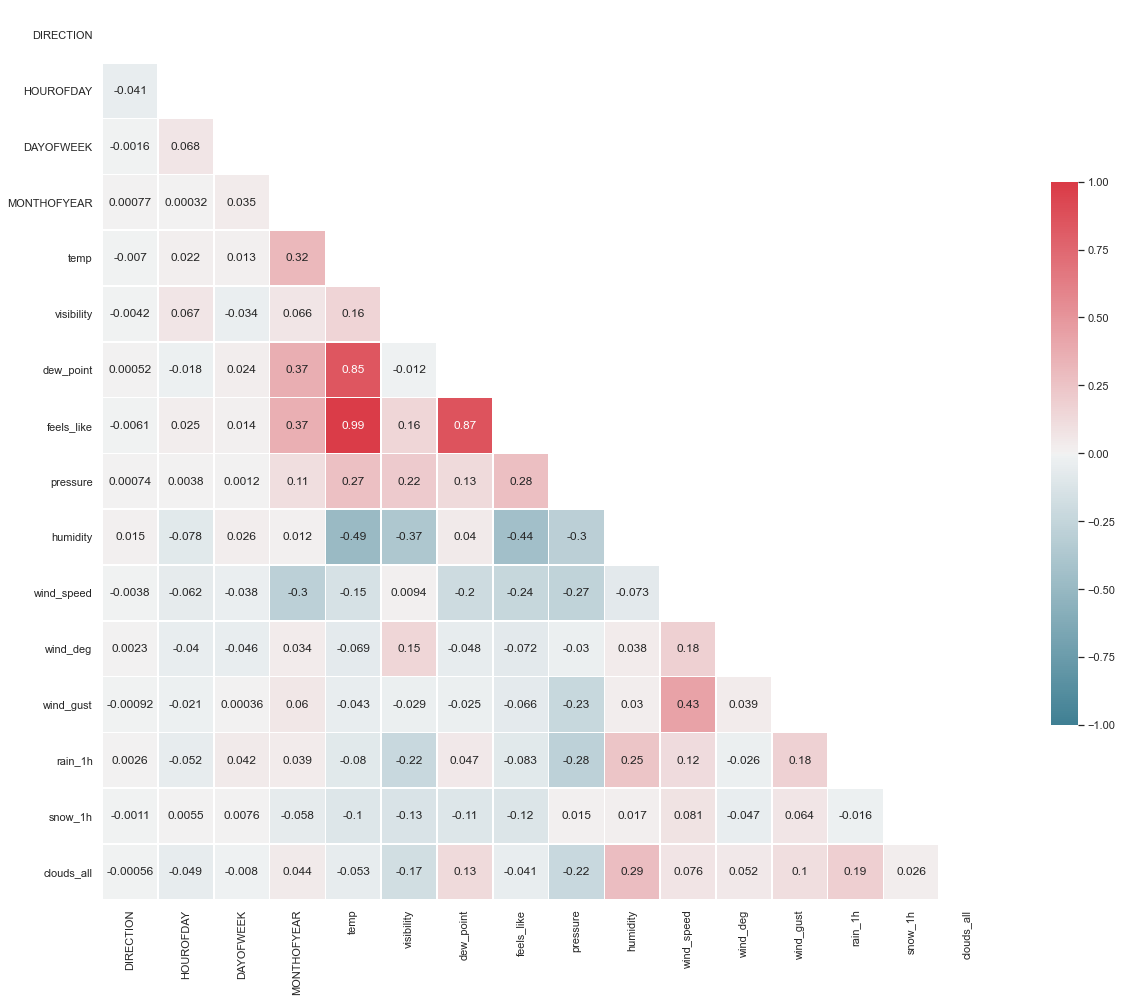

In [16]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = X_train[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

plt.savefig('continuous_features_correlations.pdf')

### Plot interaction between continuous features and target feature

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,TRIPTIME(min)
wind_speed,0.045495
MONTHOFYEAR,0.037158
temp,0.024124
rain_1h,0.019992
clouds_all,0.019571
feels_like,0.019038
wind_gust,0.013492
visibility,0.008364
wind_deg,0.004333
DIRECTION,-0.007920


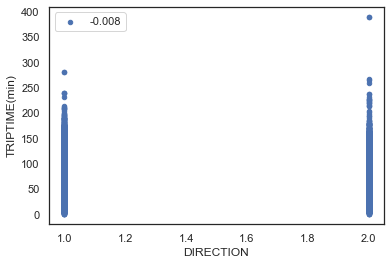

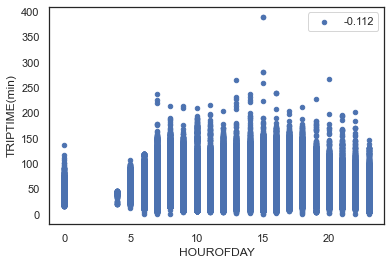

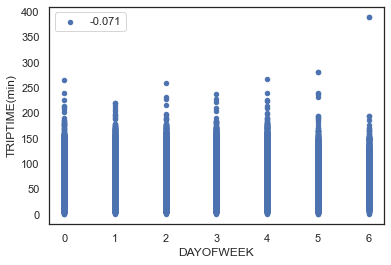

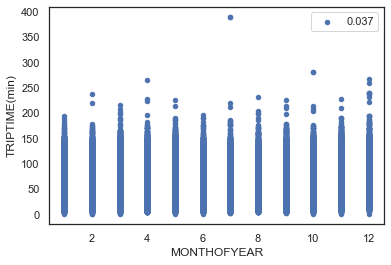

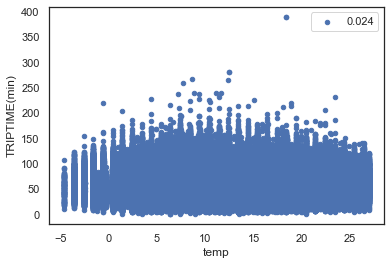

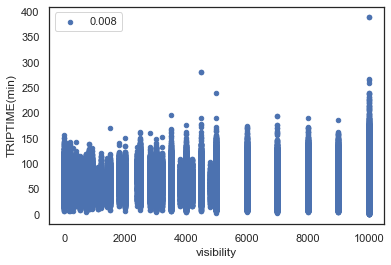

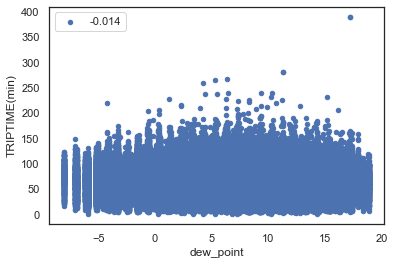

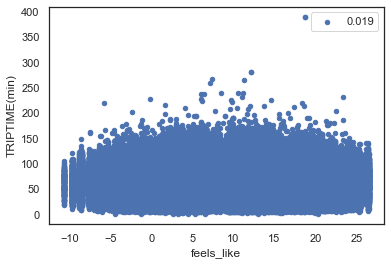

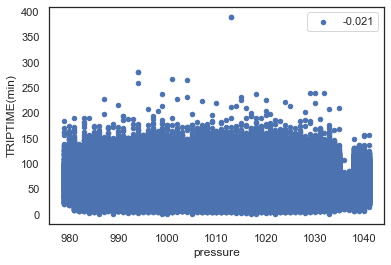

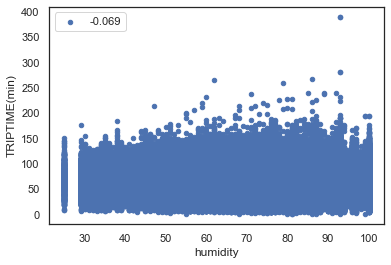

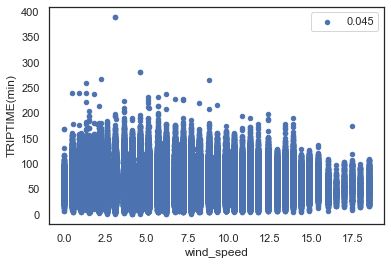

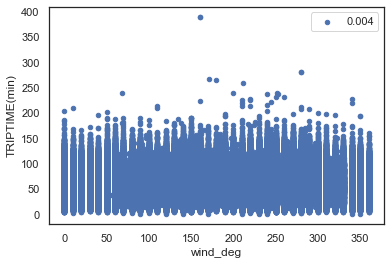

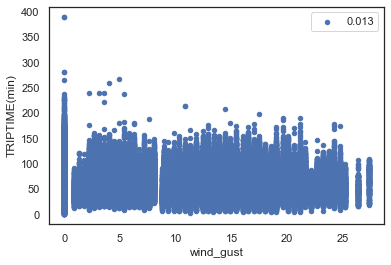

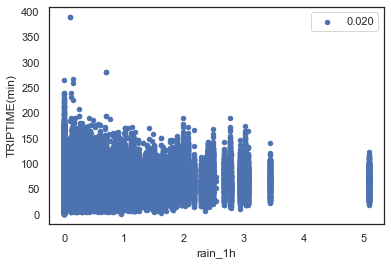

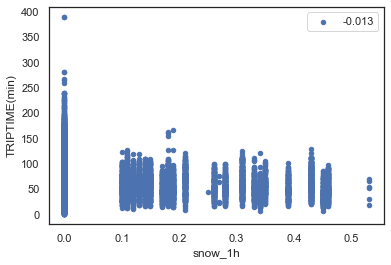

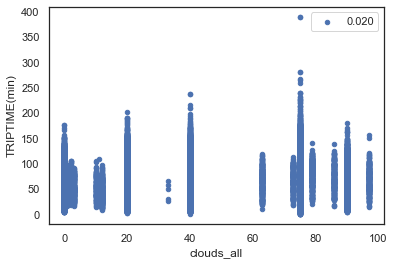

In [18]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_columns]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "TRIPTIME(min)"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="TRIPTIME(min)", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['TRIPTIME(min)']).sort_values('TRIPTIME(min)', ascending=False)
corr_df

### Plot interaction between categorical features and target feature.

In [19]:
# we will create temp dataframe for these plots, mergeing X_train and y_train
y_train = y_train.astype("category")
df_temp= pd.concat([X_train, y_train], axis=1)
df_temp.dtypes

DAYOFSERVICE           datetime64[ns]
TRIPID                       category
LINEID                       category
ROUTEID                      category
DIRECTION                     float64
HOUROFDAY                     float64
DAYOFWEEK                     float64
MONTHOFYEAR                   float64
temp                          float64
visibility                    float64
dew_point                     float64
feels_like                    float64
pressure                      float64
humidity                      float64
wind_speed                    float64
wind_deg                      float64
wind_gust                     float64
rain_1h                       float64
snow_1h                       float64
clouds_all                    float64
weather_main                 category
weather_description          category
TRIPTIME(min)                category
dtype: object

<Figure size 432x288 with 0 Axes>

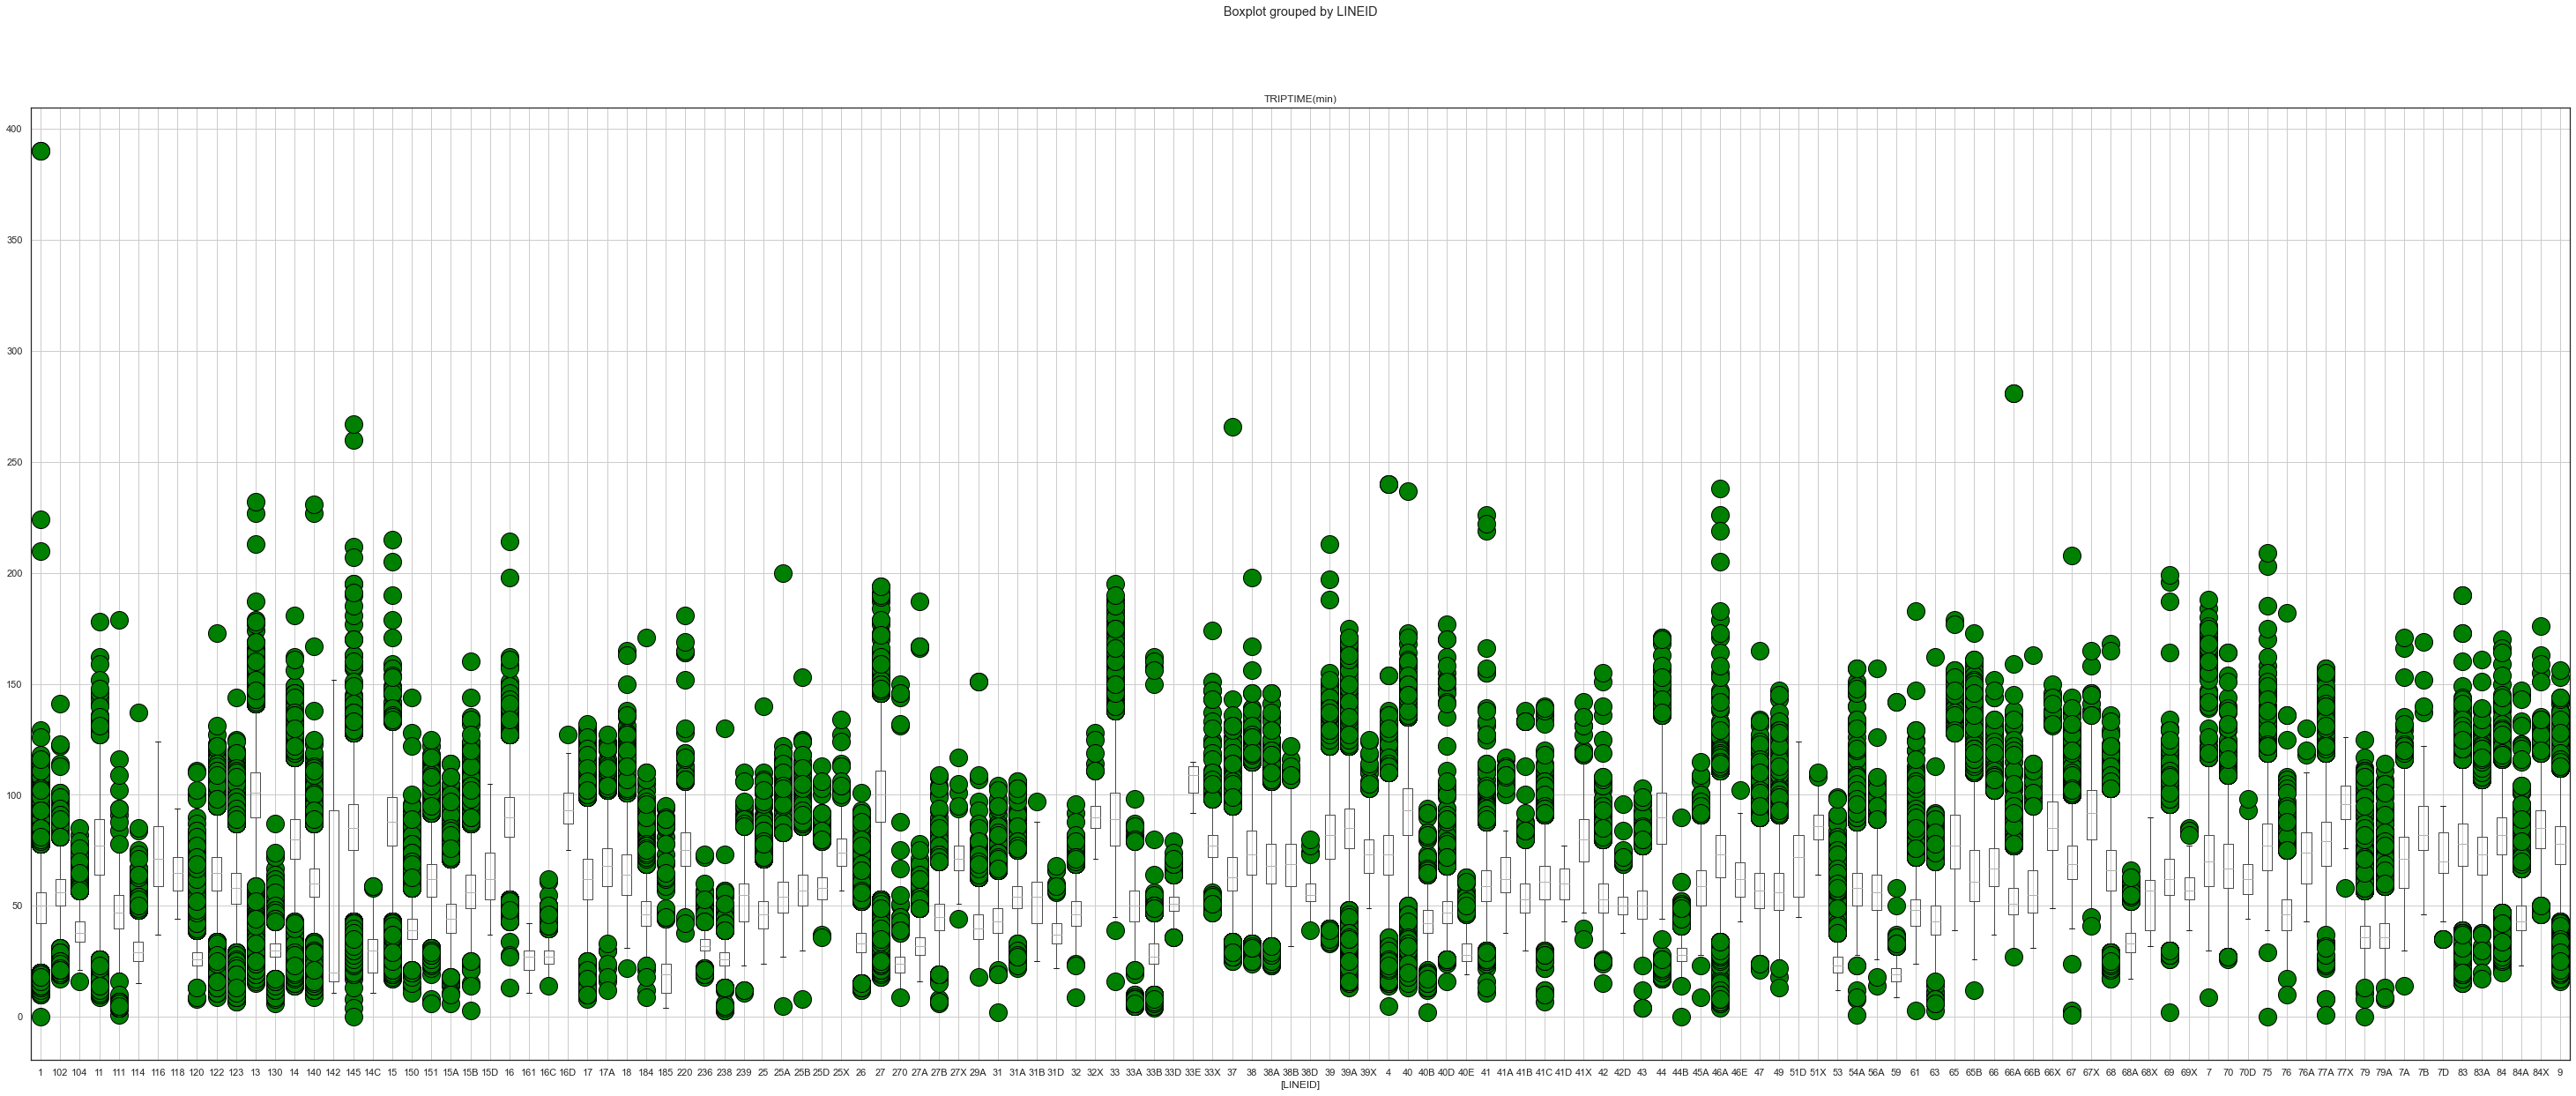

In [20]:
# LINEID vs TRIPTIME(min)
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=20, 
                  linestyle='none')
df_temp.boxplot(column=['TRIPTIME(min)'], by=['LINEID'], flierprops=flierprops, figsize=(50,20))

plt.savefig('LINEID_vs_target_feature_correlations.pdf')

<Figure size 432x288 with 0 Axes>

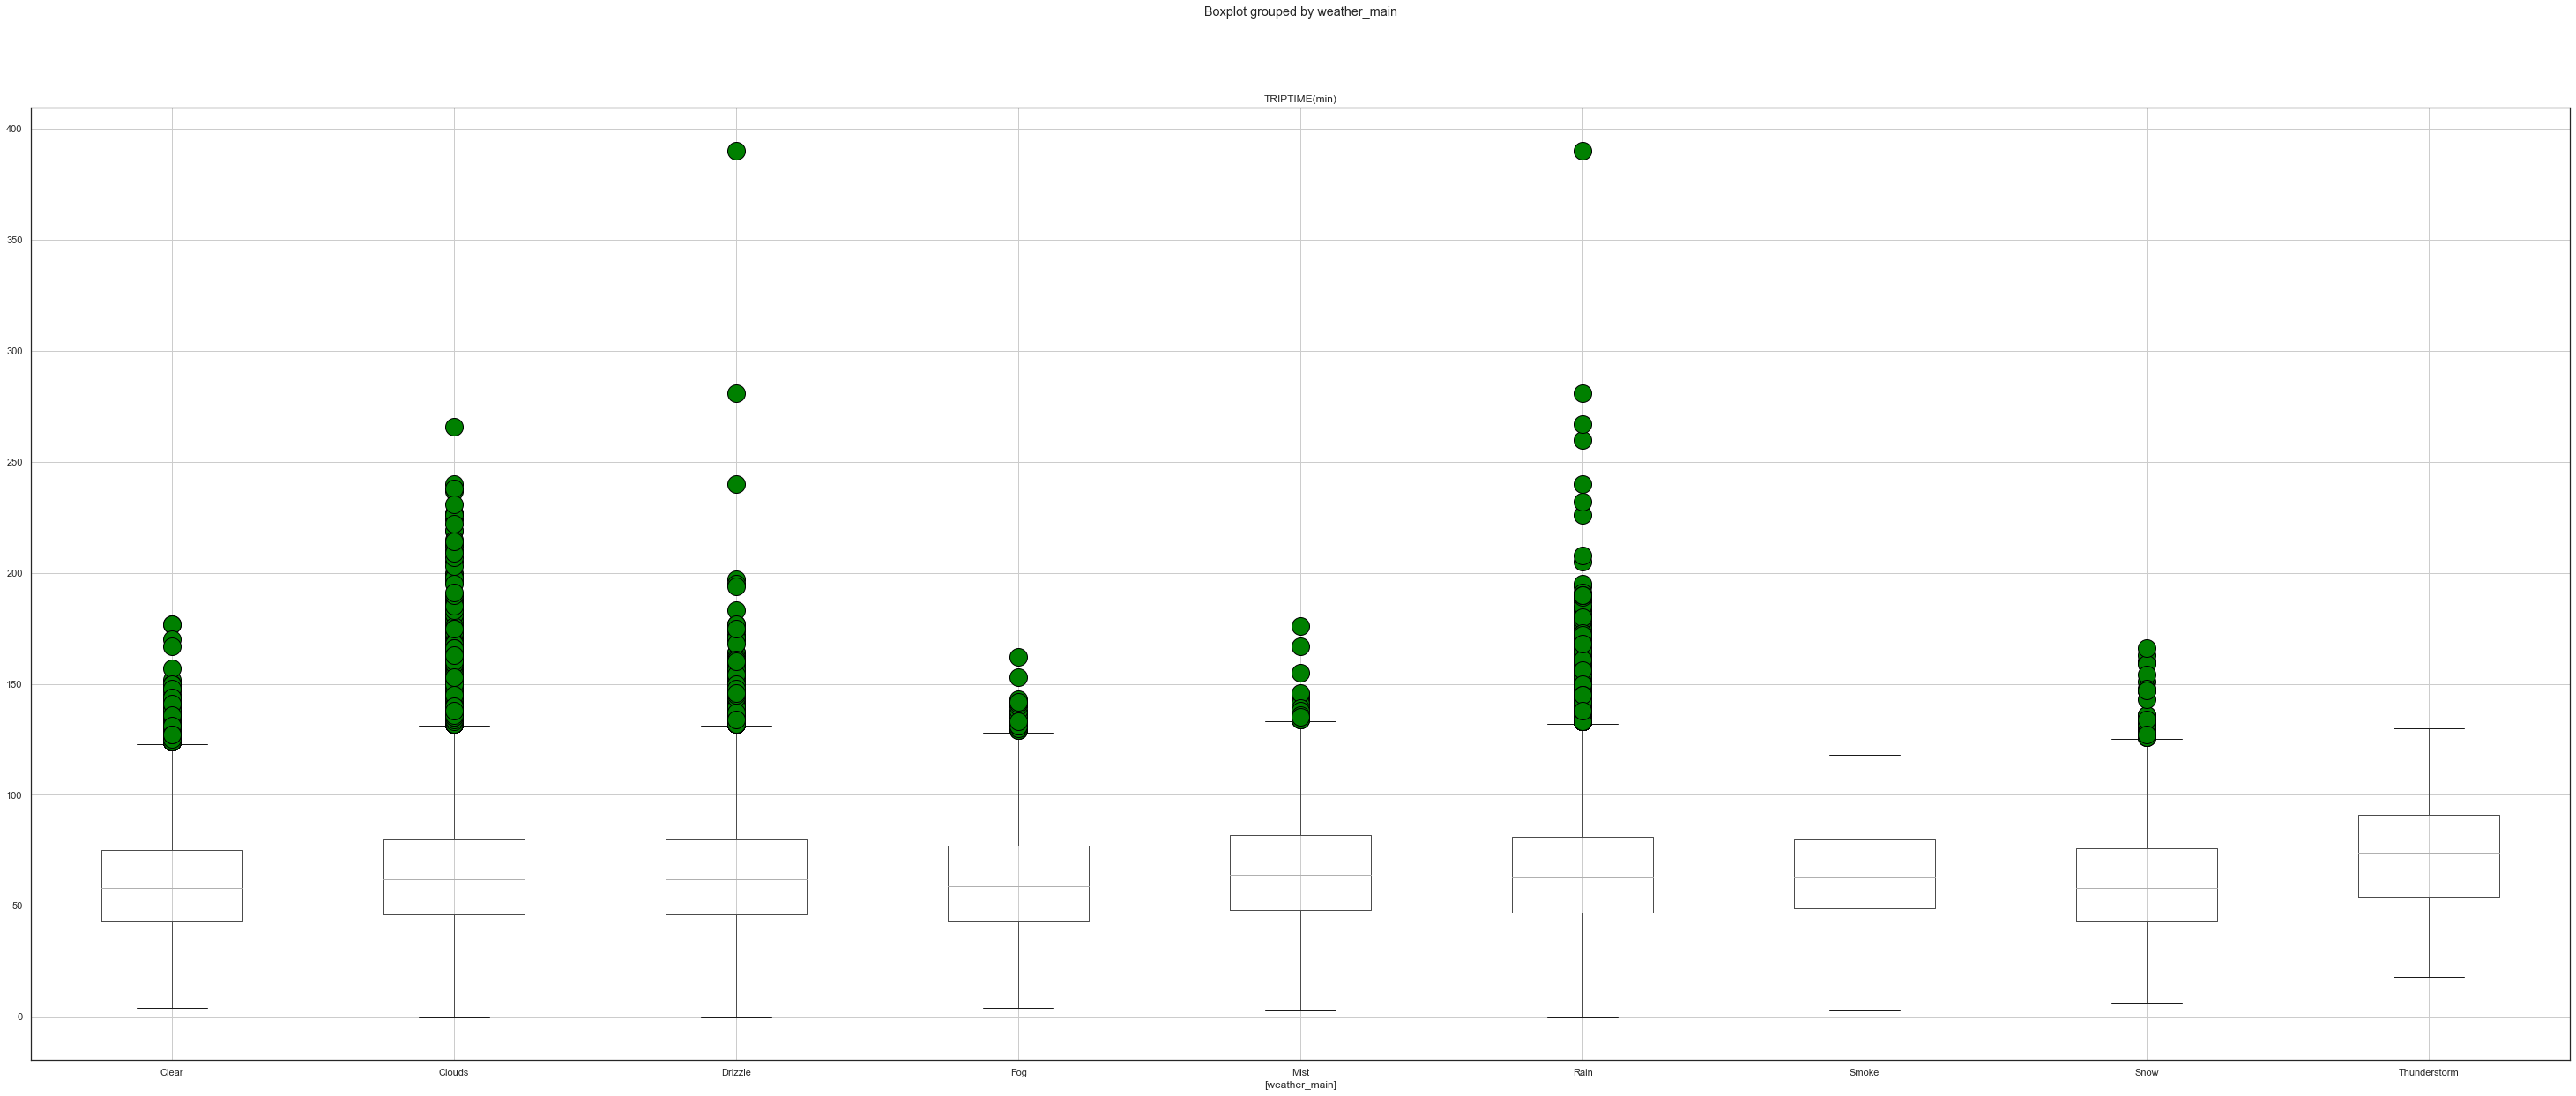

In [21]:
# weather_main vs TRIPTIME(min)
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=20, 
                  linestyle='none')
df_temp.boxplot(column=['TRIPTIME(min)'], by=['weather_main'], flierprops=flierprops, figsize=(50,20))

plt.savefig('weather_main_vs_target_feature_correlations.pdf')

<Figure size 432x288 with 0 Axes>

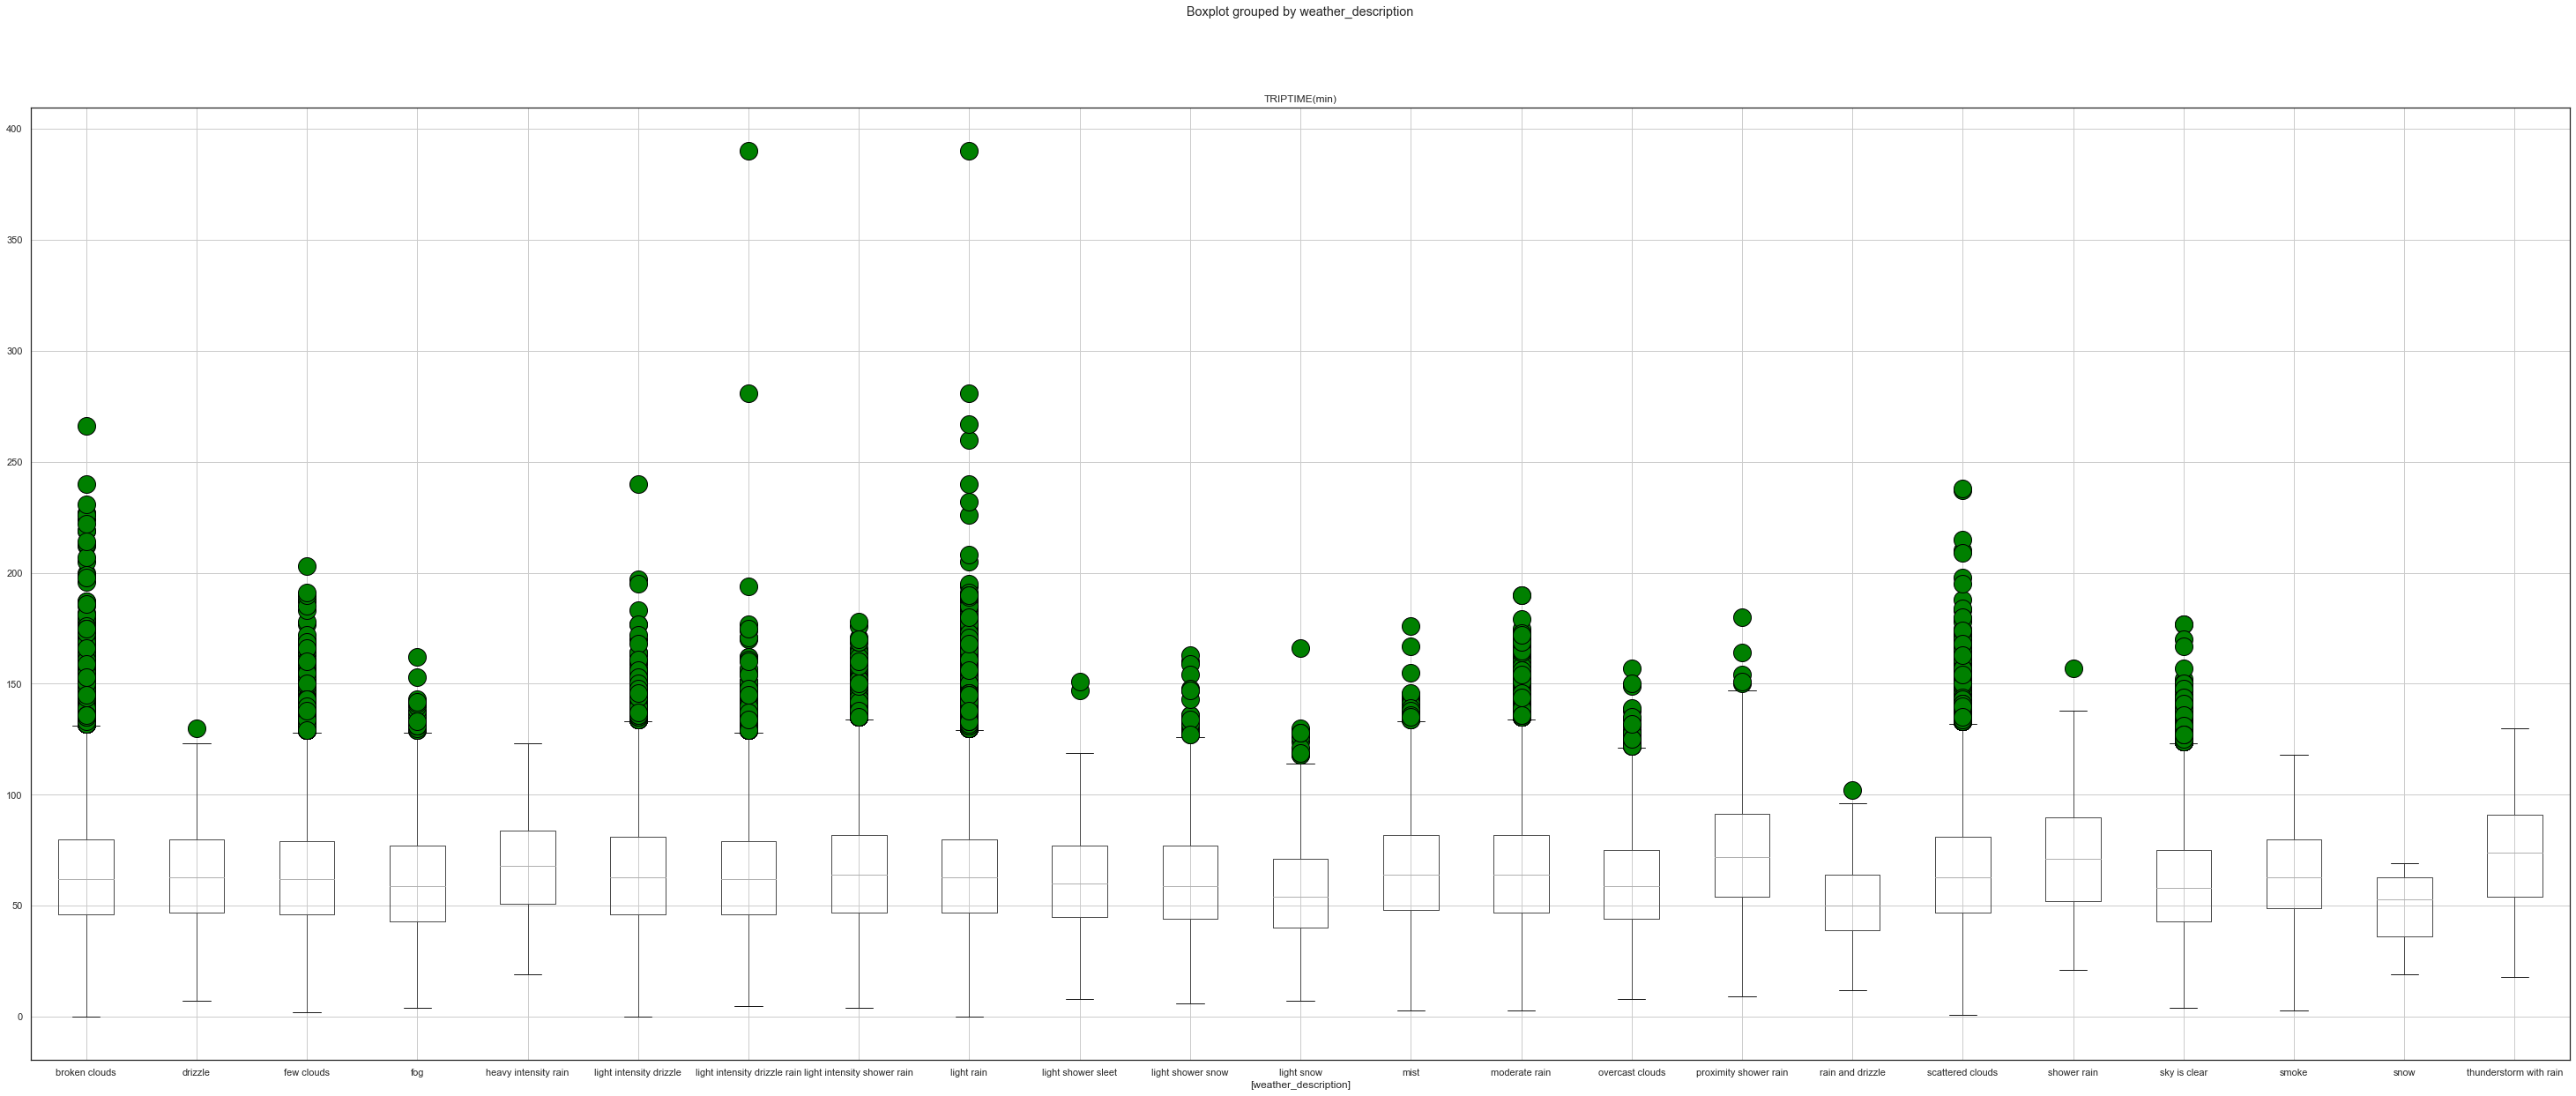

In [22]:
# weather_description vs TRIPTIME(min)
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=20, 
                  linestyle='none')
df_temp.boxplot(column=['TRIPTIME(min)'], by=['weather_description'], flierprops=flierprops, figsize=(50,20))

plt.savefig('weather_description_vs_target_feature_correlations.pdf')

### Prepare dataset for modeling

We will remove the categorical features of TRIPID and ROUTEID because of high cardinality.

In [23]:
#Copy the original version of dataset
dftrips_ver1 = dftrips_clean.loc[:, (dftrips_clean.columns != "TRIPID") & (dftrips_clean.columns !='ROUTEID') & (dftrips_clean.columns !='DAYOFSERVICE')]
dftrips_ver1

,LINEID,DIRECTION,TRIPTIME(min),HOUROFDAY,DAYOFWEEK,MONTHOFYEAR,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,wind_deg,wind_gust,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,68,1.0,48.0,23.0,2.0,2.0,6.39,9999.0,4.39,2.23,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
1,14,1.0,51.0,23.0,2.0,2.0,6.39,9999.0,4.39,2.23,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
2,59,1.0,13.0,23.0,2.0,2.0,6.39,9999.0,4.39,2.23,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
3,77A,1.0,61.0,23.0,2.0,2.0,6.39,9999.0,4.39,2.23,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
4,16,1.0,61.0,23.0,2.0,2.0,6.39,9999.0,4.39,2.23,1015.0,87.0,7.2,220.0,0.0,0.0,0.0,75.0,Drizzle,light intensity drizzle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249783,33,2.0,61.0,0.0,1.0,5.0,10.39,10000.0,9.31,9.91,1022.0,93.0,2.6,20.0,0.0,0.0,0.0,0.0,Clear,sky is clear
2249784,84,1.0,44.0,4.0,0.0,5.0,12.15,1500.0,11.53,11.93,1018.0,96.0,1.0,330.0,0.0,0.0,0.0,40.0,Mist,mist
2249785,84,1.0,46.0,4.0,1.0,1.0,4.39,9999.0,0.35,2.55,1005.0,75.0,2.1,170.0,0.0,0.0,0.0,75.0,Clouds,broken clouds
2249786,41,1.0,44.0,6.0,6.0,5.0,12.39,9999.0,9.41,11.83,1017.0,82.0,5.7,60.0,0.0,0.0,0.0,75.0,Rain,light intensity shower rain


In [24]:
dftrips_ver1.isna().sum()

LINEID                 0
DIRECTION              0
TRIPTIME(min)          0
HOUROFDAY              0
DAYOFWEEK              0
MONTHOFYEAR            0
temp                   0
visibility             0
dew_point              0
feels_like             0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
wind_gust              0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
dtype: int64

In [25]:
# set up dummies features
dftrips_ver1 = pd.get_dummies(dftrips_ver1, drop_first=True)
dftrips_ver1.dtypes

DIRECTION                                     float64
TRIPTIME(min)                                 float64
HOUROFDAY                                     float64
DAYOFWEEK                                     float64
MONTHOFYEAR                                   float64
                                               ...   
weather_description_shower rain                 uint8
weather_description_sky is clear                uint8
weather_description_smoke                       uint8
weather_description_snow                        uint8
weather_description_thunderstorm with rain      uint8
Length: 176, dtype: object

In [26]:
#check the dummies 
dftrips_ver1.head()

,DIRECTION,TRIPTIME(min),HOUROFDAY,DAYOFWEEK,MONTHOFYEAR,temp,visibility,dew_point,feels_like,pressure,...,weather_description_moderate rain,weather_description_overcast clouds,weather_description_proximity shower rain,weather_description_rain and drizzle,weather_description_scattered clouds,weather_description_shower rain,weather_description_sky is clear,weather_description_smoke,weather_description_snow,weather_description_thunderstorm with rain
0,1.0,48.0,23.0,2.0,2.0,6.39,9999.0,4.39,2.23,1015.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,51.0,23.0,2.0,2.0,6.39,9999.0,4.39,2.23,1015.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,13.0,23.0,2.0,2.0,6.39,9999.0,4.39,2.23,1015.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,61.0,23.0,2.0,2.0,6.39,9999.0,4.39,2.23,1015.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,61.0,23.0,2.0,2.0,6.39,9999.0,4.39,2.23,1015.0,...,0,0,0,0,0,0,0,0,0,0


Now, we will set up the continuous_columns and categorical_columns.

In [27]:
continuous_columns = dftrips_ver1.select_dtypes(include=['int64','float64']).columns.tolist()
continuous_columns.pop(0)
continuous_columns

['TRIPTIME(min)',
 'HOUROFDAY',
 'DAYOFWEEK',
 'MONTHOFYEAR',
 'temp',
 'visibility',
 'dew_point',
 'feels_like',
 'pressure',
 'humidity',
 'wind_speed',
 'wind_deg',
 'wind_gust',
 'rain_1h',
 'snow_1h',
 'clouds_all']

In [28]:
categorical_columns = dftrips_ver1.select_dtypes(include=['uint8']).columns.tolist()
categorical_columns

['LINEID_102',
 'LINEID_104',
 'LINEID_11',
 'LINEID_111',
 'LINEID_114',
 'LINEID_116',
 'LINEID_118',
 'LINEID_120',
 'LINEID_122',
 'LINEID_123',
 'LINEID_13',
 'LINEID_130',
 'LINEID_14',
 'LINEID_140',
 'LINEID_142',
 'LINEID_145',
 'LINEID_14C',
 'LINEID_15',
 'LINEID_150',
 'LINEID_151',
 'LINEID_15A',
 'LINEID_15B',
 'LINEID_15D',
 'LINEID_16',
 'LINEID_161',
 'LINEID_16C',
 'LINEID_16D',
 'LINEID_17',
 'LINEID_17A',
 'LINEID_18',
 'LINEID_184',
 'LINEID_185',
 'LINEID_220',
 'LINEID_236',
 'LINEID_238',
 'LINEID_239',
 'LINEID_25',
 'LINEID_25A',
 'LINEID_25B',
 'LINEID_25D',
 'LINEID_25X',
 'LINEID_26',
 'LINEID_27',
 'LINEID_270',
 'LINEID_27A',
 'LINEID_27B',
 'LINEID_27X',
 'LINEID_29A',
 'LINEID_31',
 'LINEID_31A',
 'LINEID_31B',
 'LINEID_31D',
 'LINEID_32',
 'LINEID_32X',
 'LINEID_33',
 'LINEID_33A',
 'LINEID_33B',
 'LINEID_33D',
 'LINEID_33E',
 'LINEID_33X',
 'LINEID_37',
 'LINEID_38',
 'LINEID_38A',
 'LINEID_38B',
 'LINEID_38D',
 'LINEID_39',
 'LINEID_39A',
 'LINEID_39

In [29]:
features = continuous_columns + categorical_columns
features

['TRIPTIME(min)',
 'HOUROFDAY',
 'DAYOFWEEK',
 'MONTHOFYEAR',
 'temp',
 'visibility',
 'dew_point',
 'feels_like',
 'pressure',
 'humidity',
 'wind_speed',
 'wind_deg',
 'wind_gust',
 'rain_1h',
 'snow_1h',
 'clouds_all',
 'LINEID_102',
 'LINEID_104',
 'LINEID_11',
 'LINEID_111',
 'LINEID_114',
 'LINEID_116',
 'LINEID_118',
 'LINEID_120',
 'LINEID_122',
 'LINEID_123',
 'LINEID_13',
 'LINEID_130',
 'LINEID_14',
 'LINEID_140',
 'LINEID_142',
 'LINEID_145',
 'LINEID_14C',
 'LINEID_15',
 'LINEID_150',
 'LINEID_151',
 'LINEID_15A',
 'LINEID_15B',
 'LINEID_15D',
 'LINEID_16',
 'LINEID_161',
 'LINEID_16C',
 'LINEID_16D',
 'LINEID_17',
 'LINEID_17A',
 'LINEID_18',
 'LINEID_184',
 'LINEID_185',
 'LINEID_220',
 'LINEID_236',
 'LINEID_238',
 'LINEID_239',
 'LINEID_25',
 'LINEID_25A',
 'LINEID_25B',
 'LINEID_25D',
 'LINEID_25X',
 'LINEID_26',
 'LINEID_27',
 'LINEID_270',
 'LINEID_27A',
 'LINEID_27B',
 'LINEID_27X',
 'LINEID_29A',
 'LINEID_31',
 'LINEID_31A',
 'LINEID_31B',
 'LINEID_31D',
 'LINEID_

In [30]:
#Setting up the train/test split

# y is the target
y = dftrips_ver1["TRIPTIME(min)"]
# X is everything else
X = dftrips_ver1.drop(["TRIPTIME(min)"],1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",dftrips_ver1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  2249788
training range (70%):	 rows 0 to 1574851
test range (30%): 	 rows 1574851 to 2249788


In [31]:
print(X)

         DIRECTION  HOUROFDAY  DAYOFWEEK  MONTHOFYEAR   temp  visibility  \
0              1.0       23.0        2.0          2.0   6.39      9999.0   
1              1.0       23.0        2.0          2.0   6.39      9999.0   
2              1.0       23.0        2.0          2.0   6.39      9999.0   
3              1.0       23.0        2.0          2.0   6.39      9999.0   
4              1.0       23.0        2.0          2.0   6.39      9999.0   
...            ...        ...        ...          ...    ...         ...   
2249783        2.0        0.0        1.0          5.0  10.39     10000.0   
2249784        1.0        4.0        0.0          5.0  12.15      1500.0   
2249785        1.0        4.0        1.0          1.0   4.39      9999.0   
2249786        1.0        6.0        6.0          5.0  12.39      9999.0   
2249787        1.0        4.0        1.0          5.0  13.39      9999.0   

         dew_point  feels_like  pressure  humidity  ...  \
0             4.39        2.

In [32]:
print(y)

0          48.0
1          51.0
2          13.0
3          61.0
4          61.0
           ... 
2249783    61.0
2249784    44.0
2249785    46.0
2249786    44.0
2249787    44.0
Name: TRIPTIME(min), Length: 2249788, dtype: float64


### train a linear regression model to predict the target feature

In [33]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

In [34]:
#Print out the weights that have been learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['DIRECTION', 'HOUROFDAY', 'DAYOFWEEK', 'MONTHOFYEAR', 'temp',
       'visibility', 'dew_point', 'feels_like', 'pressure', 'humidity',
       ...
       'weather_description_moderate rain',
       'weather_description_overcast clouds',
       'weather_description_proximity shower rain',
       'weather_description_rain and drizzle',
       'weather_description_scattered clouds',
       'weather_description_shower rain', 'weather_description_sky is clear',
       'weather_description_smoke', 'weather_description_snow',
       'weather_description_thunderstorm with rain'],
      dtype='object', length=175)

Coeficients are: 
 [-5.44378763e-01 -5.12624738e-01 -7.35300413e-01  3.12280104e-01
 -1.36802849e-02 -8.09933956e-05 -4.05318231e-01  2.43309211e-01
 -4.57730738e-02 -1.55236884e-01  3.88042258e-01 -3.53403108e-03
 -1.24386823e-01  2.12078599e+00 -5.68875269e+00 -6.81657767e-03
  7.32067783e+00 -9.57180158e+00  2.97560335e+01 -1.95809278e+00
 -1.82777960e+01  2.

In [35]:
# calculate the prediction
multiple_linreg_predictions_train = multiple_linreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   TRIPTIME(min)  Predicted
0            NaN  38.614590
1           51.0  52.385451
2            NaN  84.114756
3            NaN  80.742213
4           61.0  43.267177
5           22.0  76.600938
6           64.0  61.750231
7           20.0  71.932561
8            NaN  64.831427
9           26.0  51.839777


In [36]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))
        

In [37]:
printMetrics(y_train, multiple_linreg_predictions_train)


MAE:  9.520369365307285
RMSE:  13.12954944745786
R2:  0.693013027359215


In [38]:
linreg_predictions = multiple_linreg.predict(X_test)

print("\nPredictions with linear regression: \n")
actual_vs_predicted_linreg = pd.concat([y_test, pd.DataFrame(linreg_predictions, columns=['Predicted'], index=y_test.index)], axis=1)
print(actual_vs_predicted_linreg)


Predictions with linear regression: 

         TRIPTIME(min)  Predicted
851866            23.0  27.616760
1322106           80.0  73.763227
2045644           48.0  52.653372
2143355          100.0  72.858469
1013786           81.0  67.473315
...                ...        ...
1565192           84.0  92.600497
2175066           97.0  85.719750
1698736          106.0  79.867042
1365832           85.0  86.155364
1383899          102.0  95.731269

[674937 rows x 2 columns]


In [39]:
printMetrics(y_test, linreg_predictions)


MAE:  9.544974063016614
RMSE:  13.151461409877168
R2:  0.6928047285541303


In [40]:
def linreg_cross_validation(X_set,y_set,k):
    
    linreg_Results = {}
    
    print("=======================MAE===========================")
    MAE_scores = -cross_val_score(LinearRegression(), X_set,y_set, scoring='neg_mean_absolute_error', cv=k)
    print(MAE_scores)
    print("Avg MAE score over 10 folds:", np.mean(MAE_scores))
    print("Stddev MAE score over 10 folds:", np.std(MAE_scores))
    linreg_Results['MAE'] = np.mean(MAE_scores)
    
    print("\n=====================RMSE==========================")
    RMSE_scores = -cross_val_score(LinearRegression(), X_set,y_set, scoring='neg_mean_squared_error', cv=k)
    print(RMSE_scores)
    rmse = RMSE_scores**0.5
    print("Avg RMSE score over 10 folds:", np.mean(rmse))
    print("Stddev RMSE score over 10 folds:", np.std(rmse))
    linreg_Results['RMSE'] = np.mean(rmse)
    
    print("\n======================R2===========================")
    R2_scores = cross_val_score(LinearRegression(), X_set,y_set, scoring='r2', cv=k)
    print(R2_scores)
    print("Avg R2 score over 10 folds:", np.mean(R2_scores))
    print("Stddev R2 score over 10 folds:", np.std(R2_scores))
    linreg_Results['R2'] = np.mean(R2_scores)
    
    linreg_DF = pd.DataFrame.from_dict(linreg_Results, orient = 'index', columns=['Linear_Regression'])
    return linreg_DF
    

In [41]:
linreg_cross_validation(X_train,y_train,10)

=======================MAE===========================
[9.48200706 9.52349008 9.47886928 9.51888892 9.55436094 9.55151941
 9.51539262 9.5366223  9.54872524 9.50436504]
Avg MAE score over 10 folds: 9.521424088350535
Stddev MAE score over 10 folds: 0.025825572559256153

=====================RMSE==========================
[170.65854589 172.98393756 170.08672904 172.12214896 173.89914801
 172.74250187 172.28314601 172.43618014 174.47640671 172.53678311]
Avg RMSE score over 10 folds: 13.1308911223088
Stddev RMSE score over 10 folds: 0.04744537694436223

======================R2===========================
[0.69561641 0.69307915 0.69538623 0.69312029 0.68988476 0.6924396
 0.69252509 0.69377901 0.68937077 0.69426213]
Avg R2 score over 10 folds: 0.6929463451451067
Stddev R2 score over 10 folds: 0.0019531276250372293


,Linear_Regression
MAE,9.521424
RMSE,13.130891
R2,0.692946


### train a lazzo regression model to predict the target feature

In [42]:
#Initializing the Lasso Regressor with Normalization Factor as True
lasso_reg = Lasso(normalize=True)

In [43]:
# Train a lazzo regression model using all continuous and categorical features.
lasso_reg.fit(X_train,y_train)

Lasso(normalize=True)

In [44]:
# calculate the prediction
lasso_reg_predictions_train = lasso_reg.predict(X_train)

In [45]:
print("\nPredictions with lazzo regression: \n")
actual_vs_predicted_laz_reg = pd.concat([y_train, pd.DataFrame(lasso_reg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with lazzo regression: 

   TRIPTIME(min)  Predicted
0            NaN  38.614590
1           51.0  52.385451
2            NaN  84.114756
3            NaN  80.742213
4           61.0  43.267177
5           22.0  76.600938
6           64.0  61.750231
7           20.0  71.932561
8            NaN  64.831427
9           26.0  51.839777


In [46]:
printMetrics(y_train, lasso_reg_predictions_train)


MAE:  19.305875601810026
RMSE:  23.696808019062193
R2:  0.0


In [47]:
lazreg_predictions = lasso_reg.predict(X_test)

print("\nPredictions with lazzo regression: \n")
actual_vs_predicted_laz_reg = pd.concat([y_test, pd.DataFrame(lazreg_predictions, columns=['Predicted'], index=y_test.index)], axis=1)
print(actual_vs_predicted_laz_reg)


Predictions with lazzo regression: 

         TRIPTIME(min)  Predicted
851866            23.0  63.448906
1322106           80.0  63.448906
2045644           48.0  63.448906
2143355          100.0  63.448906
1013786           81.0  63.448906
...                ...        ...
1565192           84.0  63.448906
2175066           97.0  63.448906
1698736          106.0  63.448906
1365832           85.0  63.448906
1383899          102.0  63.448906

[674937 rows x 2 columns]


In [48]:
printMetrics(y_test, lazreg_predictions)


MAE:  19.333801934079265
RMSE:  23.728312139971408
R2:  -4.376451421261862e-07
